In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc) 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm as color

# SparkSession is now the new entry point of Spark that replaces the old SQLContext and HiveContext. Note that the old SQLContext and HiveContext are kept for backward compatibility.
# SparkSession provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with DataFrame and Dataset APIs. All the functionality available with sparkContext are also available in sparkSession.

In [2]:
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [3]:
df = spark.read.csv("train.csv", inferSchema = True, header = True)
df.show(1)
df.columns
df.count()

AnalysisException: 'Path does not exist: file:/home/alinemati/Yandex.Disk/Nirvana/DATA/18- Hadoop & Spark Introduction OPEN/train.csv;'

In [4]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
#SQL QUERIES
df.select('*').show(2)
# WE CAN ALSO PASS SQL QUERIES DIRECTLY TO DATAFRAME  BY REGISTERING IT AS TABLE
df.registerTempTable('data_table')
sqlContext.sql('select * from data_table').show(2)
# we can perform similarly any sql query in similar way

+------+------------+--------------------+
|    id|label_actual|                text|
+------+------------+--------------------+
| 34098|           9|Selena Gomez s Sp...|
|126472|          11|Mitch McConnell S...|
+------+------------+--------------------+
only showing top 2 rows

+------+------------+--------------------+
|    id|label_actual|                text|
+------+------------+--------------------+
| 34098|           9|Selena Gomez s Sp...|
|126472|          11|Mitch McConnell S...|
+------+------------+--------------------+
only showing top 2 rows



In [6]:
# Understanding udf function

In [7]:
#clean func

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize,sent_tokenize
stop_words = set(stopwords.words('english')) 
ps=PorterStemmer()  
def clean_text(text):
    text=text.lower()
    text=''.join(c for c in text if c not in punctuation)
    word_tokens = word_tokenize(text) 
    cleaned_sentence = [w for w in word_tokens if not w in stop_words] 
    cleaned_sentence=[ps.stem(w) for w in cleaned_sentence]  
    cleaned_sentence =" ".join(c for c in cleaned_sentence)
    return cleaned_sentence

udf_function = udf(clean_text,StringType()) # function name and return type should be passed as arguments
df = df.withColumn("cleaned_text", udf_function("text"))

In [8]:
df.explain(True)

== Parsed Logical Plan ==
'Project [id#10, label_actual#11, text#12, clean_text('text) AS cleaned_text#72]
+- AnalysisBarrier
      +- Relation[id#10,label_actual#11,text#12] csv

== Analyzed Logical Plan ==
id: int, label_actual: int, text: string, cleaned_text: string
Project [id#10, label_actual#11, text#12, clean_text(text#12) AS cleaned_text#72]
+- Relation[id#10,label_actual#11,text#12] csv

== Optimized Logical Plan ==
Project [id#10, label_actual#11, text#12, clean_text(text#12) AS cleaned_text#72]
+- Relation[id#10,label_actual#11,text#12] csv

== Physical Plan ==
*(2) Project [id#10, label_actual#11, text#12, pythonUDF0#77 AS cleaned_text#72]
+- BatchEvalPython [clean_text(text#12)], [id#10, label_actual#11, text#12, pythonUDF0#77]
   +- *(1) FileScan csv [id#10,label_actual#11,text#12] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/Users/dharmanathpatil/Desktop/pres/__sessions__/119/info/train.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<

In [9]:
df.show()

+------+------------+--------------------+--------------------+
|    id|label_actual|                text|        cleaned_text|
+------+------------+--------------------+--------------------+
| 34098|           9|Selena Gomez s Sp...|selena gomez spri...|
|126472|          11|Mitch McConnell S...|mitch mcconnel sa...|
|167309|           5|this fast chargin...|fast charg sync m...|
|214589|           0|exclusive sanjay ...|exclus sanjay dut...|
| 85052|           9|Adriana Lima s St...|adriana lima styl...|
|114130|           8|High Fiber Diet H...|high fiber diet h...|
| 99576|          11|Bernie Sanders An...|berni sander top ...|
|226414|          14|hull city manager...|hull citi manag p...|
|148595|           3|cbse orders re ex...|cbse order exam d...|
|146968|           6|The Good News Abo...|good news adhd fa...|
| 91302|          11|SEC Chief Mary Jo...|sec chief mari jo...|
| 81423|           8|WATCH Find Yourse...|watch find quit l...|
|138166|           9|How Did We Almost..

In [10]:
df2 = df.select([column for column in df.columns if column in ['cleaned_text']])

In [11]:
df2.show(2)

+--------------------+
|        cleaned_text|
+--------------------+
|selena gomez spri...|
|mitch mcconnel sa...|
+--------------------+
only showing top 2 rows



In [12]:
df = df.withColumn('len', f.size(f.split(f.col('cleaned_text'), ' ')))

In [13]:
df.show(2)

+------+------------+--------------------+--------------------+---+
|    id|label_actual|                text|        cleaned_text|len|
+------+------------+--------------------+--------------------+---+
| 34098|           9|Selena Gomez s Sp...|selena gomez spri...| 24|
|126472|          11|Mitch McConnell S...|mitch mcconnel sa...| 17|
+------+------------+--------------------+--------------------+---+
only showing top 2 rows



In [14]:
# len_histogram = df.select('len').rdd.flatMap(lambda x: x).histogram(11)
# import pandas as pd
# pd.DataFrame(
#     list(zip(*len_histogram)), 
#     columns=['bin', 'frequency']
# ).set_index(
#     'bin'
# ).plot(kind='bar');

In [15]:
# df = df.filter("len >='100' AND len <='0'")
# df.cache().count() # cache will make rdd to store the data hence helpful for reuse

# #not removing samples

In [16]:
%%time
df.cache().count()

CPU times: user 16.1 ms, sys: 9.68 ms, total: 25.8 ms
Wall time: 5min 29s


240498

# KMEANS CLUSTERING

Hashing TF

MLlib has two algorithms that compute TF-IDF: HashingTF and IDF, both in the mllib.feature package. HashingTF computes a term frequency vector of a given size from a document. In order to map terms to vector indices, it uses a technique known as the hashing trick. Within a language like English, there are hundreds of thousands of words, so tracking a distinct mapping from each word to an index in the vector would be expensive. Instead, HashingTF takes the hash code of each word modulo a desired vector size, S, and thus maps each word to a number between 0 and S–1. This always yields an S-dimensional vector, and in practice is quite robust even if multiple words map to the same hash code. The MLlib developers recommend setting S between  and .

In [20]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline



# cleaning and hashing tf for text representations
tokenizer = Tokenizer(inputCol="text", outputCol="tokens") # WE CAN USE UDF FUNCTIONS TO CLEAN OR ML PACKAGE FROM PYSPARK DOES
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=2000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)


pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)
dataset.show(5)

(trainingData, testData) = dataset.randomSplit([0.6, 0.4], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

kmeans = KMeans(k=17)

kmeans_model=kmeans.fit(trainingData)
test_predictions = kmeans_model.transform(testData)

evaluator = ClusteringEvaluator()

silhouette_test_predictions = evaluator.evaluate(test_predictions)
print("Silhouette score for kmeans " + str(silhouette_test_predictions))




test_predictions.cache()

+------+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+
|    id|label_actual|                text|        cleaned_text|len|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|
+------+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+
| 34098|           9|Selena Gomez s Sp...|selena gomez spri...| 24|[selena, gomez, s...|  [selena, gomez, s...|(2000,[30,39,40,1...|(2000,[30,39,40,1...|
|126472|          11|Mitch McConnell S...|mitch mcconnel sa...| 17|[mitch, mcconnell...|  [mitch, mcconnell...|(2000,[18,70,116,...|(2000,[18,70,116,...|
|167309|           5|this fast chargin...|fast charg sync m...| 73|[this, fast, char...|  [fast, charging, ...|(2000,[116,222,29...|(2000,[116,222,29...|
|214589|           0|exclusive sanjay ...|exclus sanjay dut...| 24|[exclusiv

DataFrame[id: int, label_actual: int, text: string, cleaned_text: string, len: int, tokens: array<string>, stopWordsRemovedTokens: array<string>, rawFeatures: vector, features: vector, prediction: int]

In [17]:

test_predictions.count()

95861

In [18]:
test_predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        12| 1561|
|         1| 5673|
|        13| 2535|
|        16|  621|
|         6|    1|
|         3| 3278|
|         5| 6975|
|         9|  558|
|         4| 2311|
|         8|  219|
|         7|   12|
|        10|  332|
|        11| 1042|
|        14|   95|
|         2|  877|
|         0|69771|
+----------+-----+



In [21]:
kmeans_df= test_predictions.toPandas()

In [25]:
# kmeans_df['prediction'], 
test_predictions.show(2)

+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+----------+
| id|label_actual|                text|        cleaned_text|len|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+----------+
|  0|           9|Blake Lively s We...|blake live wed dr...| 16|[blake, lively, s...|  [blake, lively, w...|(2000,[123,219,39...|(2000,[123,219,39...|         0|
|  4|           7|Kohlrabi Recipes ...|kohlrabi recip co...| 12|[kohlrabi, recipe...|  [kohlrabi, recipe...|(2000,[276,352,40...|(2000,[276,352,40...|         1|
+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [20]:
class_to_id = {'Arts, Culture & Entertainment': 0,
                'Business and Finance': 1,
                            'Crime': 2,
                            'Education': 3,
                            'Environment': 4,
                            'Family & Parenting': 6,
                            'Food & drink': 7,
                            'Health & Fitness': 8,
                            'Home & Living / Lifestyle & Beauty': 9,
                            'Media': 10,
                            'Politics': 11,
                            'Religion': 12,
                            'Society': 13,
                            'Sports': 14,
                            'Travel & Leisure': 15,
                            'Science & Technology': 5,
                            'Automotive':16}
id_to_class = {class_to_id[key]:key for key in class_to_id.keys()}
kmeans_df['label_class'] = kmeans_df['label_actual'].map(id_to_class) 
kmeans_df['pred_class']=kmeans_df['prediction'].map(id_to_class)

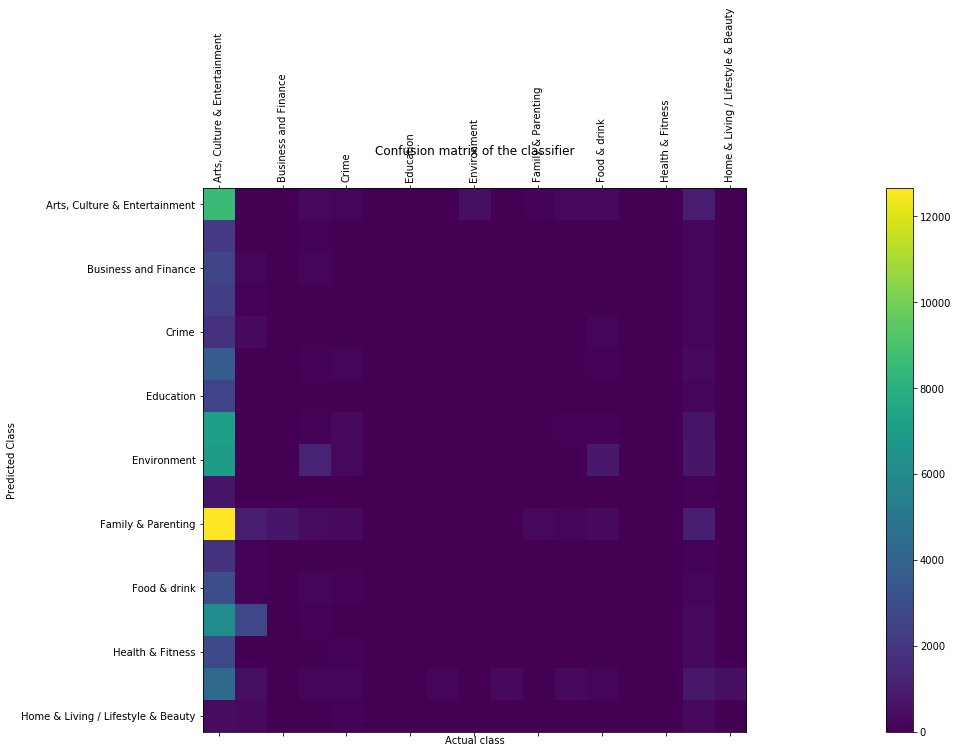

In [39]:

labels =list(class_to_id.keys())

cm = confusion_matrix(kmeans_df['label_class'],kmeans_df['pred_class'], labels)

fig = plt.figure(figsize=(50,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

fig.colorbar(cax,cmap="Wistia")
plt.xticks(rotation='vertical')
ax.set_xticklabels([''] + labels,)
ax.set_yticklabels([''] + labels)
plt.xlabel('Actual class')
plt.ylabel('Predicted Class')
plt.title('Confusion matrix of the classifier',loc='center',)
plt.show();


LOGISTIC REGRESSION

In [78]:
kmeans_df.head(2)

,id,label_actual,text,cleaned_text,len,tokens,stopWordsRemovedTokens,rawFeatures,features,prediction,label_class
0,41657,11,Sunday Roundup . This week the GOP debate circ...,sunday roundup week gop debat circu pull miami...,104,"[sunday, roundup, ., this, week, the, gop, deb...","[sunday, roundup, ., week, gop, debate, circus...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,Politics
1,216206,0,dhadak javed akhtar and shabana azmi praise ja...,dhadak jave akhtar shabana azmi prais janhvi k...,108,"[dhadak, javed, akhtar, and, shabana, azmi, pr...","[dhadak, javed, akhtar, shabana, azmi, praise,...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.5289235352047745, 0.0, 0.0, 0.0, 0.0, ...",4,"Arts, Culture & Entertainment"


In [46]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import ClusteringEvaluator,MulticlassClassificationEvaluator

In [49]:
trainingData.show(2)

+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+
| id|label_actual|                text|        cleaned_text|len|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|
+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+
| 36|           9|Denise Richards S...|denis richard sty...| 18|[denise, richards...|  [denise, richards...|(2000,[12,104,312...|(2000,[12,104,312...|
| 52|           7|How to Make Bang ...|make bang blue ch...|  8|[how, to, make, b...|  [make, bang, blue...|(2000,[246,1056,1...|(2000,[246,1056,1...|
+---+------------+--------------------+--------------------+---+--------------------+----------------------+--------------------+--------------------+
only showing top 2 rows



In [47]:

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label_actual', maxIter=10)

lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)


In [50]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='label_actual')
evaluator.evaluate(predictions)

0.5984228644668914

# Classification

In [53]:
# Random Forest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label_actual", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)


evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol='label_actual')
evaluator.evaluate(predictions)

0.15555868892975863

# pyspark dataframe basics and ranking (dense rank)

In [62]:

from pyspark.sql.types import IntegerType, DateType,FloatType

In [93]:
df = spark.read.csv("500_Person_Gender_Height_Weight_Index.csv", inferSchema = True, header = True)

In [94]:
df.show(2)
df.count()

+------+------+------+-----+
|Gender|Height|Weight|Index|
+------+------+------+-----+
|  Male|   174|    96|    4|
|  Male|   189|    87|    2|
+------+------+------+-----+
only showing top 2 rows



500

In [77]:
# TO CHANGE DATAFRAME COLUMN TYPES
df = df.withColumn("Weight", df["Weight"].cast(FloatType()))
df.show(2)
df = df.withColumn("Weight", df["Weight"].cast(IntegerType()))

+------+------+------+---+
|Gender|Height|Weight| ID|
+------+------+------+---+
|  Male|   174|  96.0|  4|
|  Male|   189|  87.0|  2|
+------+------+------+---+
only showing top 2 rows



In [69]:
#To rename columns
df = df.withColumnRenamed("Index", "ID")
df.show(2)

+------+------+------+---+
|Gender|Height|Weight| ID|
+------+------+------+---+
|  Male|   174|  96.0|  4|
|  Male|   189|  87.0|  2|
+------+------+------+---+
only showing top 2 rows



In [72]:
# order dataframe
df.sort(df.Weight.desc()).show(10)

+------+------+------+---+
|Gender|Height|Weight| ID|
+------+------+------+---+
|  Male|   166| 160.0|  5|
|Female|   164| 160.0|  5|
|  Male|   178| 160.0|  5|
|  Male|   168| 160.0|  5|
|Female|   184| 160.0|  5|
|  Male|   145| 160.0|  5|
|Female|   163| 159.0|  5|
|Female|   196| 159.0|  5|
|Female|   162| 159.0|  5|
|Female|   142| 159.0|  5|
+------+------+------+---+
only showing top 10 rows



In [76]:
#Flitering
df.filter(df['Weight'] <100).count() 
#aggregration
df.groupBy("Gender").count().sort("count", ascending = False).show(10)

218

+------+-----+
|Gender|count|
+------+-----+
|Female|  255|
|  Male|  245|
+------+-----+



In [59]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, min

df.select("Gender", "height",
          rank().over(Window.orderBy("height")).alias("rank")).show()

+------+------+----+
|Gender|height|rank|
+------+------+----+
|  Male|   140|   1|
|  Male|   140|   1|
|  Male|   140|   1|
|Female|   140|   1|
|  Male|   140|   1|
|  Male|   140|   1|
|Female|   140|   1|
|  Male|   140|   1|
|Female|   141|   9|
|  Male|   141|   9|
|  Male|   141|   9|
|  Male|   141|   9|
|Female|   141|   9|
|  Male|   141|   9|
|  Male|   141|   9|
|Female|   141|   9|
|  Male|   142|  17|
|Female|   142|  17|
|Female|   142|  17|
|Female|   142|  17|
+------+------+----+
only showing top 20 rows



In [79]:
# Udf function for calculating bms value
# BMI = Weight (kg) / Height (m)²
def Bmi(height,weight):
    bmi=height/weight
    return bmi

df = df.withColumn("bmi", Bmi(df['height'],df['weight']))

df.show(10)

+------+------+------+---+------------------+
|Gender|Height|Weight| ID|               bmi|
+------+------+------+---+------------------+
|  Male|   174|    96|  4|            1.8125|
|  Male|   189|    87|  2|2.1724137931034484|
|Female|   185|   110|  4|1.6818181818181819|
|Female|   195|   104|  3|             1.875|
|  Male|   149|    61|  3| 2.442622950819672|
|  Male|   189|   104|  3|1.8173076923076923|
|  Male|   147|    92|  5|1.5978260869565217|
|  Male|   154|   111|  5|1.3873873873873874|
|  Male|   174|    90|  3|1.9333333333333333|
|Female|   169|   103|  4|1.6407766990291262|
+------+------+------+---+------------------+
only showing top 10 rows



In [61]:
df.select("height",rank().over(Window.partitionBy("Gender").orderBy("height")).alias("rank")).show()

+------+----+
|height|rank|
+------+----+
|   140|   1|
|   140|   1|
|   141|   3|
|   141|   3|
|   141|   3|
|   142|   6|
|   142|   6|
|   142|   6|
|   142|   6|
|   143|  10|
|   144|  11|
|   145|  12|
|   145|  12|
|   146|  14|
|   146|  14|
|   146|  14|
|   146|  14|
|   146|  14|
|   146|  14|
|   147|  20|
+------+----+
only showing top 20 rows



In [89]:
df1 = sc.parallelize([['A1',1],['A2',2],['A3',2],['A3',2],['A2',1],['A3',1],['A1',1],['A2',3],['A3',3],['A1',3]]).toDF(("A", "Rank"))
df1.show()

+---+----+
|  A|Rank|
+---+----+
| A1|   1|
| A2|   2|
| A3|   2|
| A3|   2|
| A2|   1|
| A3|   1|
| A1|   1|
| A2|   3|
| A3|   3|
| A1|   3|
+---+----+



In [ ]:
# https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html

In [91]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window


ranked =  df1.withColumn("Ordered_rank", dense_rank().over(Window.partitionBy("A").orderBy(desc("Rank"))))

In [92]:
ranked.show()

+---+----+------------+
|  A|Rank|Ordered_rank|
+---+----+------------+
| A2|   3|           1|
| A2|   2|           2|
| A2|   1|           3|
| A3|   3|           1|
| A3|   2|           2|
| A3|   2|           2|
| A3|   1|           3|
| A1|   3|           1|
| A1|   1|           2|
| A1|   1|           2|
+---+----+------------+

